In [3]:
using DynamicalBilliards
using PyPlot
using Plots

┌ Warning: Package DynamicalBilliards does not have Plots in its dependencies:
│ - If you have DynamicalBilliards checked out for development and have
│   added Plots as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with DynamicalBilliards
│ Loading Plots into DynamicalBilliards from project dependency, future warnings for DynamicalBilliards are suppressed.
└ @ nothing nothing:840


In [109]:
# Environments
# env 1
polygon_n_vx = 5
polygon_boundary_len = 4.0
polygon_vertex = (r) -> [ [r*cos(2π*i/polygon_n_vx), r*sin(2π*i/polygon_n_vx)] for i in 1:polygon_n_vx]
polygonver = polygon_vertex(polygon_boundary_len)
# env 2
concave_quad = [[2.5,2.5],[0.0,1.0],[-2.5,2.5],[-2.5,-2.5],[2.5,-2.5]]
orthogonal_env = [[5.0, 2.0], [4.0, 2.0], [4.0, 3.0], [5.0, 3.0], [5.0, 5.0], [4.0, 5.0], [4.0, 4.0], [3.0, 4.0], [3.0, 5.0], [2.0, 5.0], [2.0, 4.0], [1.0, 4.0], [1.0, 3.0], [3.0, 3.0], [3.0, 1.0], [5.0, 1.0]]
tangent_bounce_angle = 0.2*pi
angular_vel = -0.1

-0.1

In [110]:
# Simulation construction
# Step 1: construct billiard with Splitter Wall
env_poly = polygonver
bd = Obstacle{Float64}[]
for i in eachindex(env_poly)
  starting = env_poly[i]
  ending = env_poly[mod1(i+1, length(env_poly))]
  w = ending - starting
  normal = [-w[2], w[1]]
  wall = SplitterWall(starting, ending, normal, "wall $i")
  push!(bd, wall)
end
bd = Billiard(bd)
# plot(bd)

# Step 2: Define transmission function and refraction function  
# in our case, we never want the transmission happens (yet)
transmission_p(p) = (φ, pflag, ω) -> begin
    0
end
# the refraction would be our bounce angles (with respect to the normal)
refraction(φ, pflag, ω) = tangent_bounce_angle

# Step 3: Assign the transmission function and refraction to each wall
raywall = RaySplitter(collect(1:length(env_poly)), transmission_p(0), refraction)
# Step 4: Sample start position on the boundary and create magnetic particle with those start pos to get a one bounce step


RaySplitter for indices [1, 2, 3, 4, 5]
 transmission: getfield(Main, Symbol("##63#64"))()
 refraction:   refraction
 new angular:  default
 affect:       default


In [111]:
# get atan2 from 0 to 2pi
function full_atan(y,x)
    angle = atan(y, x)
    if angle < 0
        angle += 2*pi
    end
    return angle
end

# Get the start config for a 
function get_point_on_boundary(angle)
    p = MagneticParticle(0, 0, angle, 0.000000001)
    xt, yt, vxt, vyt, att = timeseries(p, bd, 1, (raywall,))
    bounce_angle = full_atan(vyt[end], vxt[end])
    return xt[end], yt[end], bounce_angle
end


get_point_on_boundary (generic function with 1 method)

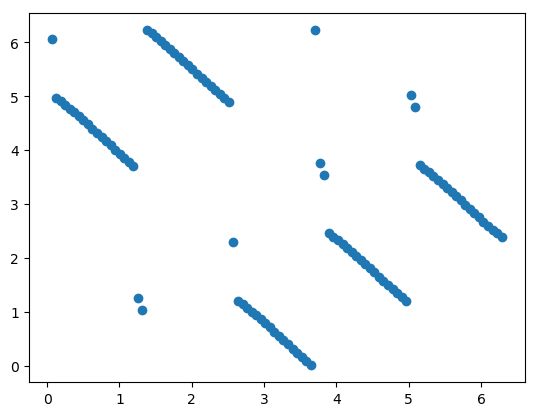

┌ Warning: Pinned particle detected!
└ @ DynamicalBilliards /Users/samararen/.julia/dev/DynamicalBilliards/src/timeseries.jl:166
┌ Warning: Pinned particle detected!
└ @ DynamicalBilliards /Users/samararen/.julia/dev/DynamicalBilliards/src/timeseries.jl:166


PyObject <matplotlib.collections.PathCollection object at 0x14b212c50>

In [112]:
# Create x(t) -> x(t+1) map
n_sample = 100
sample_start_pos = []
sample_angle = []
one_hop_pos = []
one_hop_angle = []
xt, yt = [], []

for i in eachindex(collect(1:n_sample))
    angle = 2*pi / n_sample * i
    x, y, a = get_point_on_boundary(angle)
    mp = MagneticParticle(x, y, a, angular_vel)
    xt, yt, vxt, vyt, tt = timeseries(mp, bd, 1, (raywall,))
    push!(one_hop_pos, [xt[end], yt[end]])
    push!(sample_angle, angle)
    push!(one_hop_angle, full_atan(yt[end], xt[end]))
end
DynamicalBilliards.plot(bd)
fig = PyPlot.plot(xt, yt)
close("all")
fig2 = PyPlot.scatter(sample_angle, one_hop_angle)


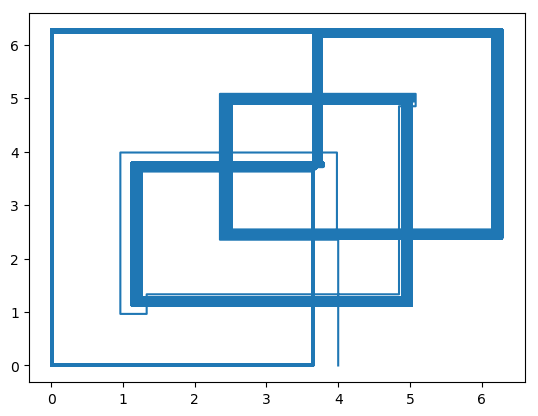

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x149890208>

In [116]:
# cobweb plot
n_cobweb = 10000
start_angle = 4.0
curr_angle = start_angle
cobweb_x = [start_angle]
cobweb_y = [0.0]
for i in eachindex(collect(1:n_cobweb))
    x, y, a = get_point_on_boundary(curr_angle)
    mp = MagneticParticle(x, y, a, angular_vel)
    xt, yt, vxt, vyt, tt = timeseries(mp, bd, 1, (raywall,))
    new_angle = full_atan(yt[end], xt[end])
    push!(cobweb_x, curr_angle)
    push!(cobweb_y, new_angle)
    push!(cobweb_x, new_angle)
    push!(cobweb_y, new_angle)
    curr_angle = new_angle
end
PyPlot.plot(cobweb_x, cobweb_y)

ffmpeg version 3.3.3 Copyright (c) 2000-2017 the FFmpeg developers
  built with Apple LLVM version 8.1.0 (clang-802.0.42)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/3.3.3 --enable-shared --enable-pthreads --enable-gpl --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma --enable-vda
  libavutil      55. 58.100 / 55. 58.100
  libavcodec     57. 89.100 / 57. 89.100
  libavformat    57. 71.100 / 57. 71.100
  libavdevice    57.  6.100 / 57.  6.100
  libavfilter     6. 82.100 /  6. 82.100
  libavresample   3.  5.  0 /  3.  5.  0
  libswscale      4.  6.100 /  4.  6.100
  libswresample   2.  7.100 /  2.  7.100
  libpostproc    54.  5.100 / 54.  5.100
Input #0, image2, from './movie/poincare_%d.png':
  Duration: 00:00:30.80, start: 0.000000, bitrate: N/A
    Stream #0:0: Video: png, rgba(pc), 720x720 [SAR 3937:3937 DAR 1:1], 20

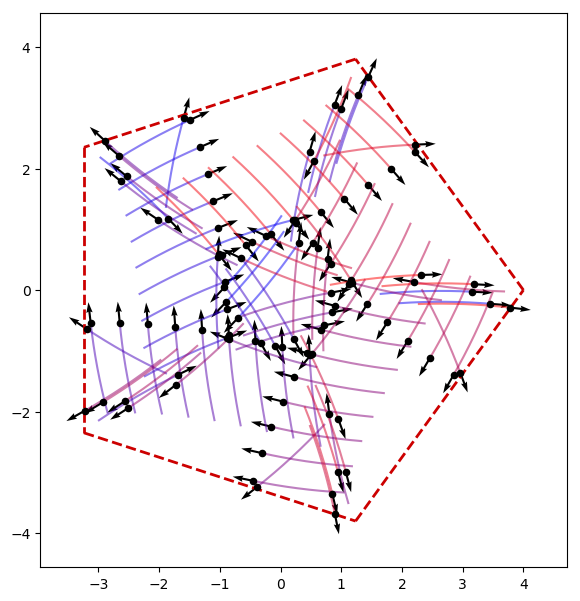

In [51]:
# Simulate multi-particle (animation)
N = 100
cs = [(i/N, 0, 1 - i/N, 0.5) for i in 1:N]
ps = [MagneticParticle(0.0, 0.0, 2*pi/N*i, angular_vel) for i in 1:N]
animate_evolution(ps, bd, 30.0, (raywall,), colors = cs, tailtime = 1.5, savename = "./movie/poincare");